In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'},
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import time
from pyDOE import lhs
import pandas as pd
import seaborn as sns 
import codecs, json
import math

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)
x_2 = np.linspace(1,-1,256)

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the SAPINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

usol =  -1/(2 * np.pi) * np.log(X**2 + Y**2) + math.e**(X*Y)*np.cos(X)

u = usol.flatten('F')[:,None] 

# Training Data

In [4]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u
    
    '''Collocation Points'''

    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train

# PINN 

$W \in \mathcal{R}^{n_{l-1}\times{n_l}}$ 

Creating sequential layers using the $\textit{class}$ tf.Module

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):

        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters

        for i in range(len(layers)-1):

            input_dim = layers[i]
            output_dim = layers[i+1]

            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv

            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))

            self.W.append(w)
            self.W.append(b)

            self.parameters +=  input_dim * output_dim + output_dim
        
        # Lagrange multipliers
        
        # Boundary terms      
        self.lagrange_1 = tf.Variable(tf.cast(tf.ones([N_u,1]), dtype = 'float64'), trainable = True) 
        
        # Residual terms
        self.lagrange_2 = tf.Variable(tf.cast(tf.ones([N_f+N_u,1]), dtype = 'float64'), trainable = True)
        
        # Circle terms
        self.lagrange_3 = tf.Variable(tf.cast(tf.ones([N_f+N_u,1]), dtype = 'float64'), trainable = True)       
    
    def evaluate(self,x):
        
        x = (x - lb)/(ub - lb) #feature scaling
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 
            
    def loss_BC(self,x,y):
        
        loss_u = y-self.evaluate(x)
        loss_u = self.lagrange_1*loss_u # element-wise,shape = (N_u,1)
        loss_u = tf.reduce_mean(tf.square(loss_u)) # squaring and averaging

        return loss_u
            
    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64')  

        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_1_f)
            tape.watch(x_2_f)

            g = tf.stack([x_1_f[:,0], x_2_f[:,0]], axis=1)

            u = self.evaluate(g)
            u_x_1 = tape.gradient(u,x_1_f)
            u_x_2 = tape.gradient(u,x_2_f)

        u_xx_1 = tape.gradient(u_x_1,x_1_f)
        u_xx_2 = tape.gradient(u_x_2,x_2_f)

        del tape

        H = 0.075

        k = x_1_f**2 + x_2_f**2 + 1
        q = 12/(np.pi * H**2) * (5/H**2 * (x_1_f**2 + x_2_f**2) - 8/H * np.sqrt(x_1_f**2 + x_2_f**2) + 3)
        q = tf.where(x_1_f**2+x_2_f**2 >= H**2, 0.0, q)

        gg = (x_1_f**2+x_2_f**2+1)*((1-x_1_f**2-x_2_f**2)*math.e**(x_1_f*x_2_f)*np.cos(x_1_f)+2*x_2_f*math.e**(x_1_f*x_2_f)*np.sin(x_1_f))-4*x_1_f*x_2_f*math.e**(x_1_f*x_2_f)*np.cos(x_1_f)+2*x_1_f*math.e**(x_1_f*x_2_f)*np.sin(x_1_f)+2/np.pi
        
        f = -k*(u_xx_1 + u_xx_2) - 2*x_1_f*u_x_1 - 2*x_2_f*u_x_2 - 2*k*q-gg
        
        f = tf.where(x_1_f**2+x_2_f**2 >= H**2, self.lagrange_2 * f, f)
        f = tf.where(x_1_f**2+x_2_f**2 < H**2, self.lagrange_3 * f, f)
        
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f 
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #store 1d grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        
        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
                
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)
        
    def adaptive_gradients(self):

        with tf.GradientTape() as tape:
            tape.watch(self.W)
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)

        grads = tape.gradient(loss_val,self.W)

        del tape

        with tf.GradientTape(persistent = True) as tape:
            tape.watch(self.lagrange_1)
            tape.watch(self.lagrange_2)
            tape.watch(self.lagrange_3)
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)

        grads_L1 = tape.gradient(loss_val,self.lagrange_1) # boundary terms
        grads_L2 = tape.gradient(loss_val,self.lagrange_2) # residual terms
        grads_L3 = tape.gradient(loss_val,self.lagrange_3)
        
        del tape

        return loss_val, grads, grads_L1, grads_L2, grads_L3

# *Loss Function*

The loss function consists of two parts:
1. **loss_BC**: MSE error of boundary losses
2. **loss_PDE**: MSE error of collocation points satisfying the PDE

**loss** = loss_BC + loss_PDE

STIFF PROBLEM
1633.4011431086053
1975.2057711514635
2373.3170814295909
2825.549557045455
3332.4068002349454
3830.1540036383303
4351.9090833174569
4771.4074146376543
4826.6063909270324
3641.3354240452909
1805.6796202079943
1092.5871744930703
820.1854903412
673.01191204095278
574.17845191598974
500.17885229123789
440.89525598916617
385.14475204034608
350.97003112795113
328.357102352175
311.44294300383564
292.83757064639741
279.32981447465056
265.66857351822819
255.07415721759261
Training time: 3433.96
Test Error: 0.07823


C:\Users\HP\AppData\Local\Temp/ipykernel_6028/747278760.py:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, u_pred, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_6028/747278760.py:81: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')


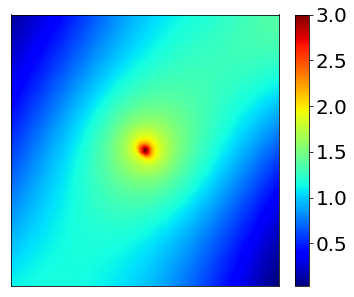

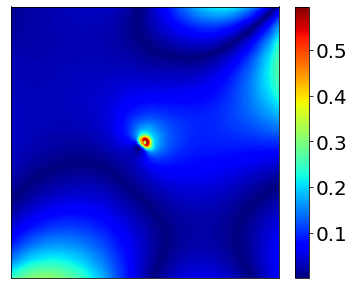

In [6]:
N_u = 400 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,1])

PINN = Sequentialmodel(layers)

start_time = time.time() 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

optimizer_L1 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

optimizer_L2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

optimizer_L3 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

num_epochs = 2500

print('STIFF PROBLEM')

for epoch in range(num_epochs):
    
        loss_value, grads, grads_L1, grads_L2, grads_L3 = PINN.adaptive_gradients()

        if epoch % 100 == 0:
            tf.print(loss_value)
        
        optimizer.apply_gradients(zip(grads, PINN.W)) #gradient descent weights 
        optimizer_L1.apply_gradients(zip([-grads_L1], [PINN.lagrange_1])) # gradient ascent adaptive coefficients of boundary residual
        optimizer_L2.apply_gradients(zip([-grads_L2], [PINN.lagrange_2])) # gradient ascent adaptive coefficients of PDE residual
        optimizer_L3.apply_gradients(zip([-grads_L3], [PINN.lagrange_3]))   
        
init_params = PINN.get_weights().numpy()
    
# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = None, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 2500,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,256),order='F') 

# Plotting

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(x_1, x_2, u_pred, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('SAPINNs-pred',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('SAPINNs-error',bbox_inches='tight')